**Imports**

In [17]:
# Importing modules
import pandas as pd
import os
import re
import nltk
import random
nltk.download('words')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation as LDA

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**Read sample reviews**

In [32]:

reviews = pd.read_csv('reviews_sample_Las_Vegas.csv')
reviews.head(5)

,business_id,name,city,state,postal_code,latitude,longitude,restaurant_rating,review_id,user_id,stars,date,text,useful,funny,cool,year
0,4srfPk1s8nlm1YusyDUbjg,"""Subway""",Las Vegas,NV,89119.0,36.064652,-115.118954,2.5,b-hPwDTtvj27RTwotZo9Gg,VvPx5CH2qzj0YWRSrDH4wQ,1,2017-09-28,Worst experience ever Alejandra was very rude ...,0,0,0,2017
1,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183.0,36.010086,-115.118656,4.5,kK7GKbOT_WDNdwRklQVBBw,EaFs9AJaVhvJmWHN69mFYg,2,2017-01-19,Tonight I decided to order our dinner and have...,0,0,0,2017
2,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183.0,36.010086,-115.118656,4.5,un45QpIsh3FA_6Ht_UBfog,D9kvOCcTvRpyUeWMdP31Qw,1,2017-05-14,Waited about an hour for the food..It is not a...,0,0,0,2017
3,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183.0,36.010086,-115.118656,4.5,4w-F0bU2Z6luQFW8ZVVhJg,d2l3L1-b8je4zWDlETvuwQ,2,2017-01-21,Definitely not a replacement for Montesanos. A...,2,0,0,2017
4,dPxZI9lrKTl5dvFfnb1_Ig,"""Trattoria Italia""",Las Vegas,NV,89183.0,36.010086,-115.118656,4.5,omww_QOSrq0Sjs8WpXr-7g,yIIDnKI9-AuKGyEVE9sQZA,2,2017-10-22,This is usually our go-to Italian restaurant. ...,0,0,0,2017


In [33]:
reviews.shape

(16866, 17)

**Text cleaning**

In [34]:
words = set(nltk.corpus.words.words())

def keep_english_words(sentence):
  return " ".join(w for w in nltk.wordpunct_tokenize(sentence) \
                  if w.lower() in words or not w.isalpha())


# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_sentence(sentence):
    lemmatized_list =  [lemmatizer.lemmatize(w , 'v') for w in nltk.wordpunct_tokenize(sentence)]
    return " ".join(w for w in lemmatized_list)

reviews['text_processed'] = reviews['text'].map(lambda x: re.sub('[,\.!?\\n]', '', x))
reviews['text_processed'] = reviews['text_processed'].map(lambda x: x.lower())
reviews['text_processed'] = reviews['text_processed'].map(lambda x: keep_english_words(x))
reviews['text_processed'] = reviews['text_processed'].map(lambda x: lemmatize_sentence(x))
# ?replace numbers with price

# Print out the first rows of papers
reviews['text_processed'].head(5)

0    worst experience ever be very rude she even st...
1    tonight i decide to order our dinner and have ...
2    about an hour for the be not an ideal place to...
3    definitely not a replacement for average food ...
4    this be usually our go - to restaurant normall...
Name: text_processed, dtype: object

**Word Cloud**

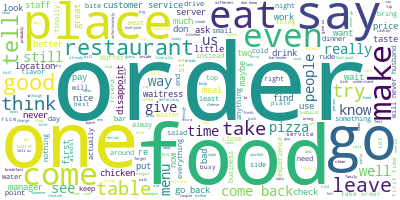

In [35]:
from wordcloud import WordCloud

negative_reviews = reviews

long_string = ','.join(list(negative_reviews['text_processed'] .values))
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()


**Helper Function**

In [0]:
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

**Fit LDA model**

In [36]:
# Initialise the count vectorizer with the English stop words
n_features = 1000
n_samples = len(negative_reviews)
count_vectorizer = CountVectorizer(max_df=0.90, min_df=10,
                                max_features=n_features,
                                stop_words='english')

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=10,
                                   max_features=n_features,
                                   stop_words='english')

count_data = count_vectorizer.fit_transform(negative_reviews['text_processed'])
tfidf_data = tfidf_vectorizer.fit_transform(negative_reviews['text_processed'])


def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

number_topics = 5
number_words = 10

lda = LDA(n_components = number_topics,
          learning_method = 'batch',
          learning_decay = 0.7,
          max_iter = 5,
          verbose = 1,
          random_state = 0,
          n_jobs=-1)

print("\nFitting LDA models with tf features, "
      "n_samples = %d and n_features = %d..."
      % (n_samples, n_features))

lda.fit(count_data)

print_topics(lda, count_vectorizer, number_words)

print("\nFitting LDA models with tfidf features, "
      "n_samples = %d and n_features = %d..."
      % (n_samples, n_features))

lda.fit(tfidf_data)

print_topics(lda, tfidf_vectorizer, number_words)


Fitting LDA models with tf features, n_samples = 16866 and n_features = 1000...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5

Topic #0:
place service time say food come just tell card like

Topic #1:
order pizza time food say just come location tell service

Topic #2:
food good like place taste chicken order eat just come

Topic #3:
say just like make come tell know don order place

Topic #4:
food come service table time order wait place server just

Fitting LDA models with tfidf features, n_samples = 16866 and n_features = 1000...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5

Topic #0:
order say time food tell service place customer manager just

Topic #1:
order location food time drive just come place service like

Topic #2:
food good chicken taste place buffet like eat order price

Topic #3:
piz

**Visualize the topics-keywords distribution.**

In [0]:
# !pip install pyLDAvis
import pyLDAvis.sklearn
vis_data = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)
pyLDAvis.display(vis_data)


**Fit NMF Model**

In [37]:
n_features = 1000
n_samples = len(negative_reviews)

count_vectorizer = CountVectorizer(max_df=0.90, min_df=10,
                                max_features=n_features,
                                stop_words='english')

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=10,
                                   max_features=n_features,
                                   stop_words='english')

count_data = count_vectorizer.fit_transform(negative_reviews['text_processed'])
tfidf_data = tfidf_vectorizer.fit_transform(negative_reviews['text_processed'])


number_topics = 5
number_words = 10

nmf = NMF(n_components=number_topics, 
          random_state=1,
          alpha=.1, 
          l1_ratio=.5)

nmf.fit(count_data)

print("Fitting the NMF model (Frobenius norm) with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
print_topics(nmf, count_vectorizer, number_words)


nmf.fit(tfidf_data)

print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
print_topics(nmf, tfidf_vectorizer, number_words)

Fitting the NMF model (Frobenius norm) with tf features, n_samples=16866 and n_features=1000...

Topic #0:
come table time service server wait sit seat restaurant leave

Topic #1:
order time chicken location come wait cheese wrong drive pick

Topic #2:
food service eat good restaurant great buffet quality cold wait

Topic #3:
like place just good taste eat really try chicken don

Topic #4:
say tell pizza just manager make know time don customer
Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=16866 and n_features=1000...

Topic #0:
come table say wait just time tell sit server leave

Topic #1:
pizza cheese delivery crust pepperoni slice driver sauce cold burn

Topic #2:
chicken taste like good eat sauce place just rice meat

Topic #3:
food service good horrible place worst terrible bad great slow

Topic #4:
order time location wrong drive say tell delivery wait phone


**Normalize Topic weights and merge to original data**

In [0]:
from sklearn.preprocessing import normalize

nmf_output = nmf.transform(tfidf_data)
topic_df = pd.DataFrame(normalize(nmf_output, norm='l1'), \
                                             columns = ['Topic 0', 'Topic 1',\
                                                        'Topic 2', 'Topic 3',\
                                                        'Topic 4'])
negative_reviews_f = pd.concat([negative_reviews, topic_df], axis=1)


**Look at random examples from each topic to make sense of the topics**

In [40]:
pd.set_option('display.max_colwidth', -1)  
pd.set_option('display.max_columns', 500)

dominant_topic = np.argmax(topic_df.values, axis=1)
negative_reviews_f['dominant_topic'] = dominant_topic

num_samples = 10

for i in range(number_topics):
  print('\nReviews with dominant topic', str(i))
  random_index = random.sample(list(negative_reviews_f[negative_reviews_f['dominant_topic'] == i].index),num_samples)  
  print(negative_reviews_f.iloc[random_index, [12,18,19,20,21,22]])



Reviews with dominant topic 0
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

**Identified Topics**

In [41]:
print('Topic 0 : long waitime \n\
Topic 1 : Pizza/Delivery \n\
Topic 2 : food/chicken/rice/salad/other items \n\
Topic 3 : Customer Service/rude/slow \n\
Topic 4 : Order/Delivery')

Topic 0 : long waitime 
Topic 1 : Pizza/Delivery 
Topic 2 : food/chicken/rice/salad/other items 
Topic 3 : Customer Service/rude/slow 
Topic 4 : Order/Delivery


In [0]:
negative_reviews_f.to_excel('./negative_reviews_w_topic_LasVegas.xlsx', index = False)

**References**


In [0]:
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
http://www.programmersought.com/article/6566770914/

https://medium.com/@Vishwacorp/nlp-analysis-of-yelp-restaurant-reviews-30b3d0e424a6
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
https://github.com/Vishwacorp/yelp_nlp/blob/f33f67e96bb0144fab3f4929aefb3f1c653d9248/1_extracting_reviews.ipynb